In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ishantjuyal/emotions-in-text")

print("Path to dataset files:", path)

In [2]:
!pip install cleantext

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from cleantext import clean
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.initializers import Constant
import keras_nlp
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

In [4]:
df = pd.read_csv('/kaggle/input/emotions-in-text/Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df.shape

(21459, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [7]:
df.apply(pd.isnull).sum()

Text       0
Emotion    0
dtype: int64

In [8]:
df['Emotion'].value_counts()

Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: count, dtype: int64

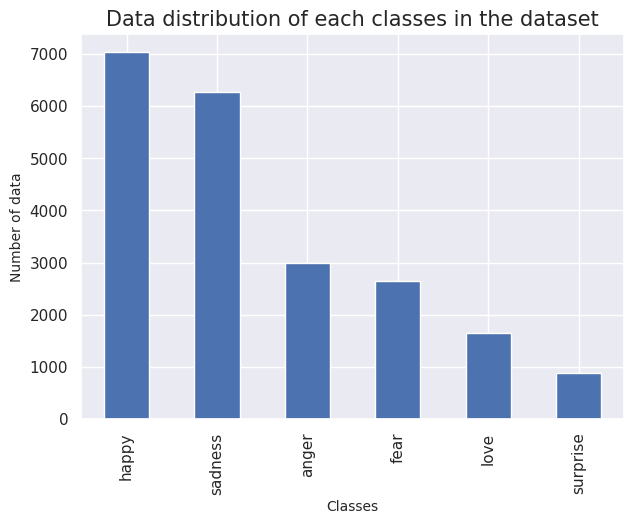

In [9]:
df['Emotion'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution of each classes in the dataset', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of data', fontsize = 10)
plt.show()

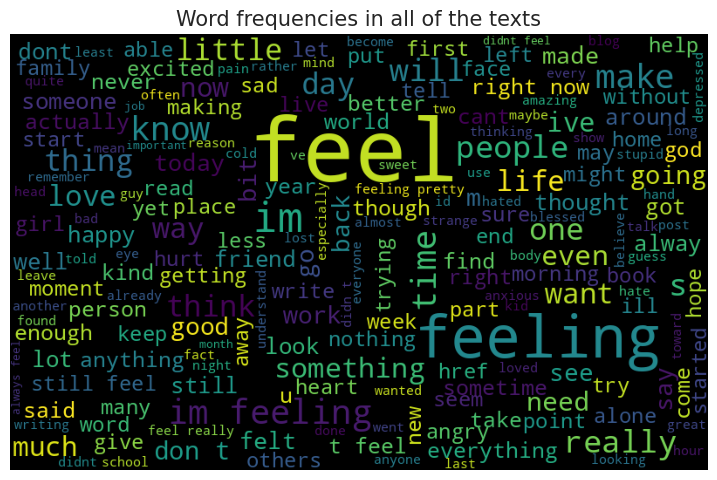

In [10]:
plt.figure(figsize = (9, 7))
all_sent = ' '.join([sentence for sentence in df['Text']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sent)
plt.imshow(word_cloud)
plt.title('Word frequencies in all of the texts', fontsize = 15)
plt.axis('off')
plt.show()

In [11]:
def word_cloud(data, emotion):
    plt.figure(figsize = (9, 7))
    all_sents = ' '.join([sentence for sentence in data['Text'][data['Emotion'] == emotion]])
    wo_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(wo_cloud)
    plt.title(emotion, fontsize = 15)
    plt.axis('off')
    plt.show()

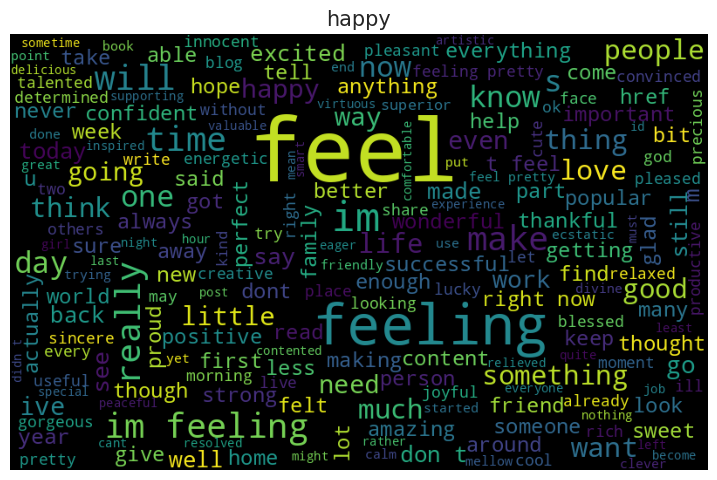

In [12]:
word_cloud(df, 'happy')

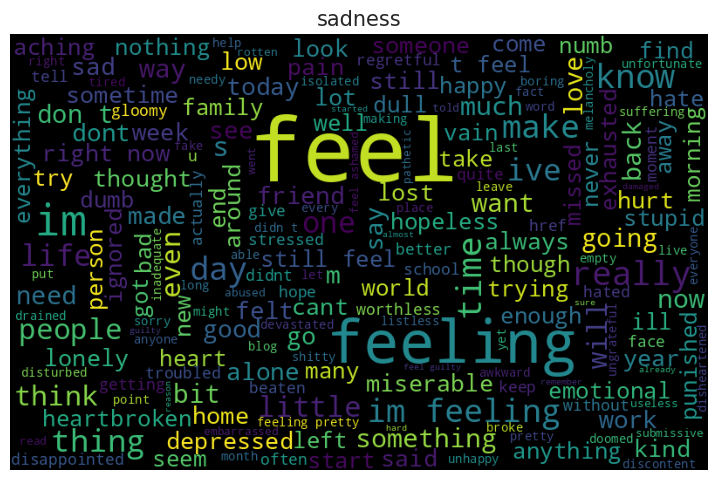

In [13]:
word_cloud(df, 'sadness')

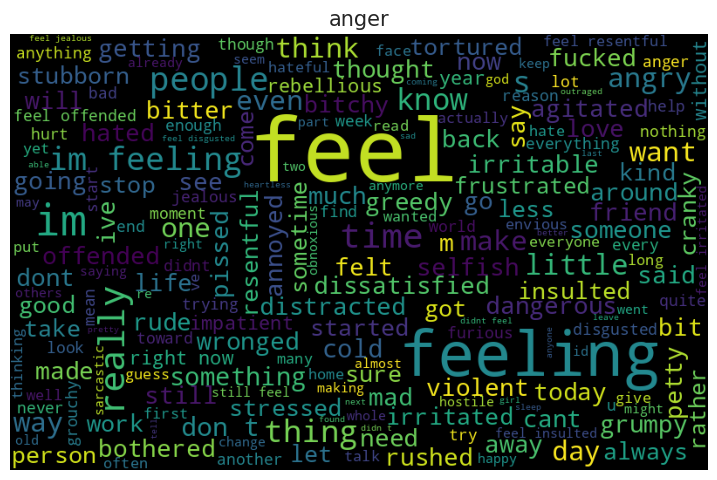

In [14]:
word_cloud(df, 'anger')

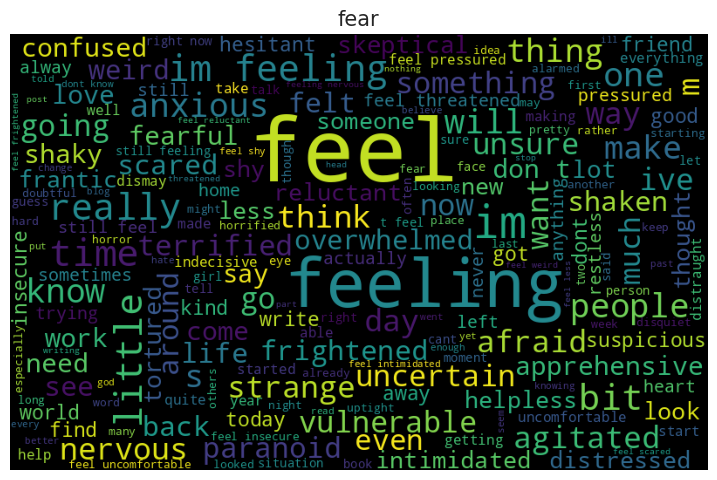

In [15]:
word_cloud(df, 'fear')

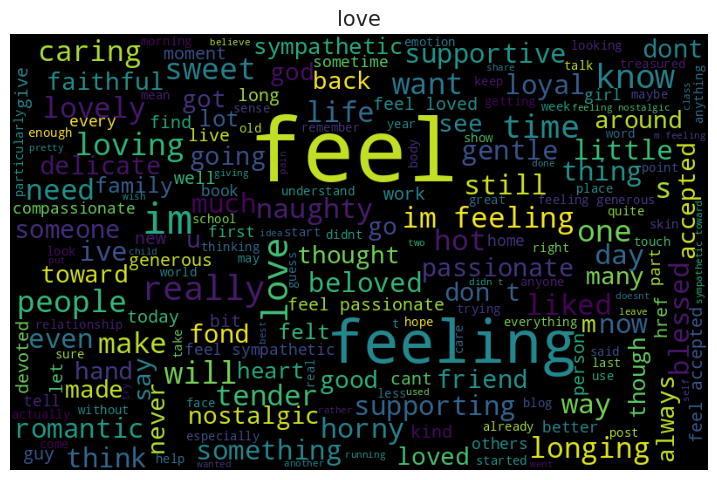

In [16]:
word_cloud(df, 'love')

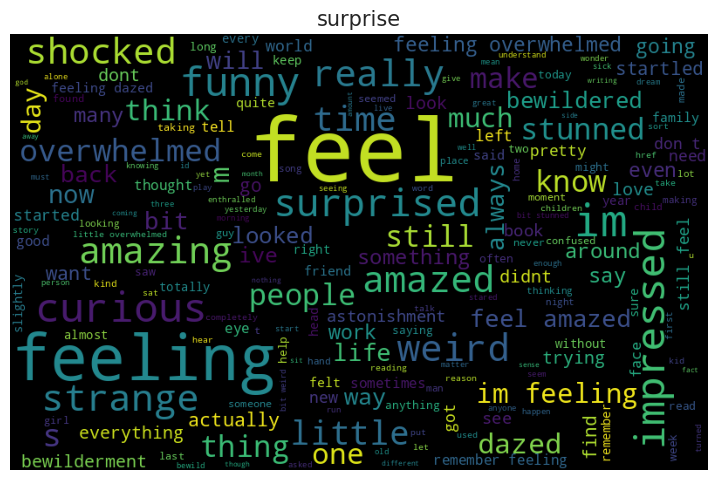

In [17]:
word_cloud(df, 'surprise')

In [18]:
df['cleaned_text'] = df['Text'].apply(clean)

In [19]:
df.head()

,Text,Emotion,cleaned_text
0,i didnt feel humiliated,sadness,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,feel grouchi


In [20]:
tokenizer = Tokenizer()

In [21]:
tokenizer.fit_on_texts(df['cleaned_text'])

In [22]:
seq = tokenizer.texts_to_sequences(df['cleaned_text'])

In [23]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

13175

In [24]:
maxlen = max([len(i) for i in seq])
maxlen

35

In [25]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [26]:
le = LabelEncoder()

In [27]:
y = le.fit_transform(df['Emotion'])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.2, random_state = 101, shuffle = True,
                                                   stratify = y)

In [29]:
print('The size of training dataset is:', len(X_train))
print('The size of test dataset is:', len(X_test))

The size of training dataset is: 17167
The size of test dataset is: 4292


In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [31]:
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding = 'utf8')
embedding_matrix = dict()
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [32]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [33]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.042895  ,  0.70670998,  0.75316   , ..., -0.54229999,
         0.11809   ,  0.39974001],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.48697999, -0.50332999, -0.54119998, ..., -0.67505997,
        -1.11319995, -0.45943001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [34]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [35]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor = 0.1, min_delta = 0.001)

In [36]:
model = Sequential()

In [37]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(5)))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))

In [38]:
model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [39]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 20, callbacks = [reduce_lr])

Epoch 1/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2993 - loss: 1.6429 - val_accuracy: 0.4042 - val_loss: 1.5358 - learning_rate: 0.0010
Epoch 2/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4048 - loss: 1.5011 - val_accuracy: 0.4409 - val_loss: 1.4440 - learning_rate: 0.0010
Epoch 3/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4508 - loss: 1.4130 - val_accuracy: 0.4706 - val_loss: 1.3661 - learning_rate: 0.0010
Epoch 4/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4754 - loss: 1.3434 - val_accuracy: 0.4927 - val_loss: 1.2886 - learning_rate: 0.0010
Epoch 5/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5034 - loss: 1.2960 - val_accuracy: 0.5253 - val_loss: 1.2362 - learning_rate: 0.0010
Epoch 6/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5289 - loss: 1.2425 - val_accuracy: 0.5510 - val_loss: 1.2085 - learning_rate: 0.0010
Epoch 7/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5538 - loss: 1.1873 - 

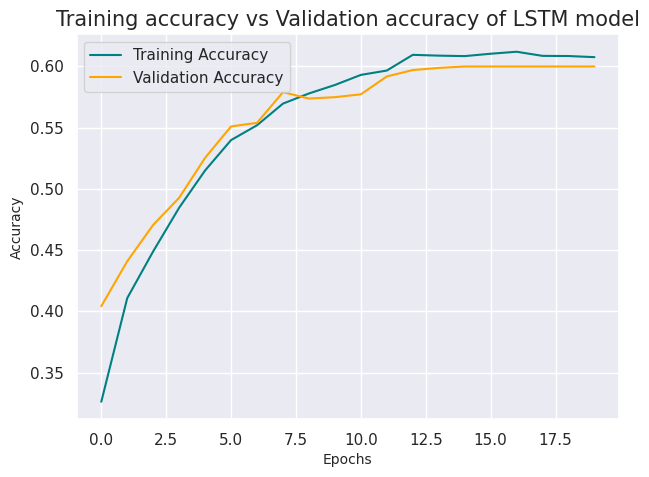

In [40]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training accuracy vs Validation accuracy of LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

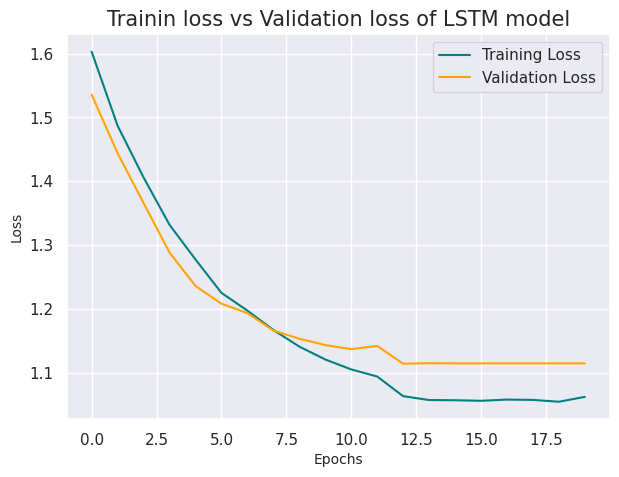

In [41]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Trainin loss vs Validation loss of LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [42]:
model.evaluate(X_test, y_test)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 1.1236


[1.1170437335968018, 0.5927306413650513]

In [100]:
df['label'] = le.fit_transform(df['Emotion'])

In [101]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size = 0.2, random_state = 101,
                                                   shuffle = True, stratify = df['label'])

In [102]:
X_train_n, X_val, y_train_n, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 101, shuffle = True,
                                                      stratify = y_train)

In [103]:
print('The size of training dataset is:', len(X_train_n))
print('The size of validation dataset is:', len(X_val))
print('The size of test dataset is:', len(X_test))

The size of training dataset is: 15450
The size of validation dataset is: 1717
The size of test dataset is: 4292


In [104]:
X_train_ragged = tf.ragged.constant(X_train_n.values)

In [105]:
X_train_tensor = tf.convert_to_tensor(X_train_ragged)

In [106]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_n.values))

In [107]:
train_dataset = train_data.cache().shuffle(len(X_train_n)).batch(8).prefetch(tf.data.AUTOTUNE)

In [108]:
X_test_ragged = tf.ragged.constant(X_test.values)

In [109]:
X_test_tensor = tf.convert_to_tensor(X_test_ragged)

In [110]:
test_data = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test.values))

In [111]:
test_dataset = test_data.cache().shuffle(len(X_test)).batch(8).prefetch(tf.data.AUTOTUNE)

In [112]:
X_val_ragged = tf.ragged.constant(X_val.values)

In [113]:
X_val_tensor = tf.convert_to_tensor(X_val_ragged)

In [114]:
val_data = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val.values))

In [115]:
valid_data = val_data.cache().shuffle(len(X_val)).batch(8).prefetch(tf.data.AUTOTUNE)

In [116]:
tokenizer2 = keras_nlp.models.BertTokenizer.from_preset('bert_large_en_uncased')

In [117]:
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer2, sequence_length = 80, truncate = 'round_robin'
)

In [68]:
bert_model = keras_nlp.models.BertClassifier.from_preset(
    'bert_large_en_uncased', preprocessor = preprocessor, num_classes = 6
)

In [69]:
bert_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [70]:
reduce_lr2 = ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor = 0.1, min_delta = 0.001)

In [71]:
history2 = bert_model.fit(train_dataset, validation_data = valid_data, epochs = 3, callbacks = [reduce_lr2])

Epoch 1/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 365s 755ms/step - accuracy: 0.8732 - loss: 0.3706 - val_accuracy: 0.8870 - val_loss: 0.3122 - learning_rate: 1.0000e-05
Epoch 3/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 365s 755ms/step - accuracy: 0.9250 - loss: 0.1966 - val_accuracy: 0.8940 - val_loss: 0.3315 - learning_rate: 1.0000e-05


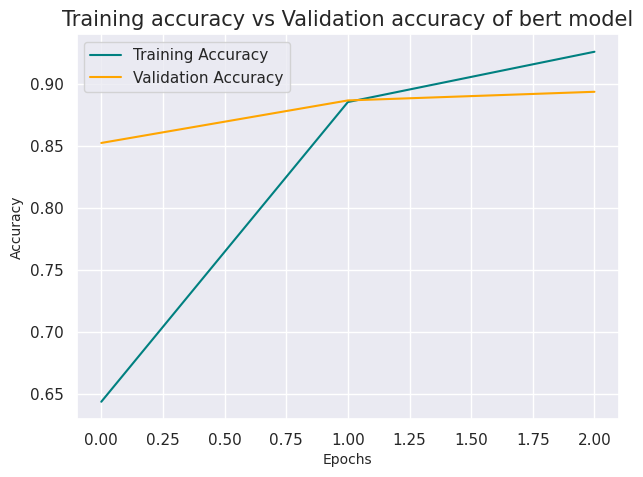

In [74]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training accuracy vs Validation accuracy of bert model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

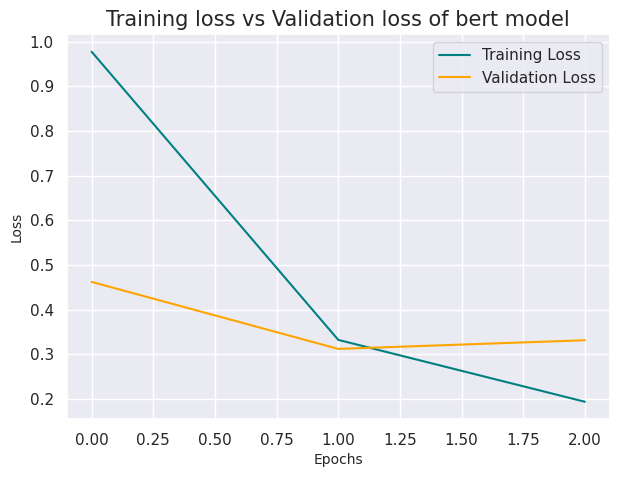

In [75]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss of bert model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [76]:
bert_model.evaluate(test_dataset)

135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 291ms/step - accuracy: 0.9086 - loss: 0.2797


[0.27878686785697937, 0.9049394130706787]

In [77]:
y_p = bert_model.predict(X_test_tensor)

135/135 ━━━━━━━━━━━━━━━━━━━━ 52s 302ms/step


In [79]:
y_pred = [np.argmax(i) for i in y_p]

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       599
           1       0.84      0.94      0.89       530
           2       0.93      0.91      0.92      1406
           3       0.81      0.70      0.75       328
           4       0.96      0.92      0.94      1253
           5       0.86      0.78      0.82       176

    accuracy                           0.90      4292
   macro avg       0.88      0.87      0.87      4292
weighted avg       0.91      0.90      0.90      4292



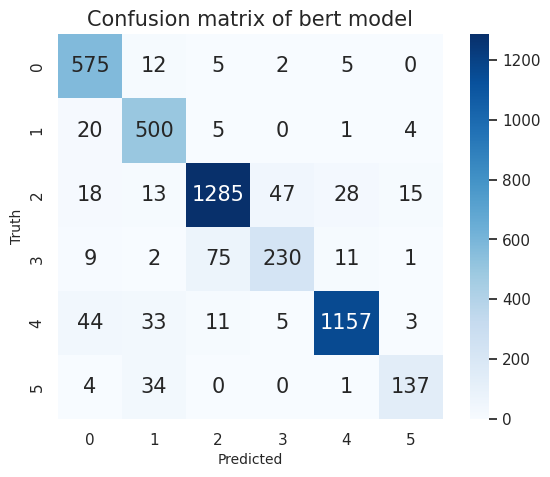

In [81]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = True, annot_kws = {'size' : 15}, fmt = 'd',
           cmap = 'Blues')
plt.title('Confusion matrix of bert model', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()